# Leadangle_model.ipynb

プラズマシートのパラメータに対してリード角の変動をみる。

In [40]:
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import B_JRM33 as BJRM
import B_equator as BEQ
import Leadangle_wave as LeadA
from TScmap import TScmap

In [41]:
# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [42]:
# 定数
MOON = 'Europa'
MU0 = 1.26E-6            # 真空中の透磁率
AMU = 1.66E-27           # [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
C = 2.99792E+8           # 光速 [m/s]
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                         names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

In [43]:
# 定数
r_orbitM = 9.38*RJ   # ORBITAL RADIUS (average) [m] (Bagenal+2015)
r_orbitC = 9.30*RJ   # ORBITAL RADIUS (closest) [m] (Bagenal+2015)
r_orbitF = 9.47*RJ   # ORBITAL RADIUS (farthest) [m] (Bagenal+2015)
MOONRADI = 1.56E+6     # MOON RADIUS [m]
OMG_E = 2.0478E-5     # 衛星の公転角速度 [rad/s]
n0 = 110             # [cm-3] (Cassidy+2013)

ne_1 = 63            # 電子数密度 [cm-3] (Bagenal+2015)
ne_2 = 158           # 電子数密度 [cm-3] (Bagenal+2015)
ne_3 = 290           # 電子数密度 [cm-3] (Bagenal+2015)

Ai_1 = 18            # 平均イオン原子量 (Bagenal+2015)
Ai_2 = 18            # 平均イオン原子量 (Bagenal+2015)
Ai_3 = 18            # 平均イオン原子量 (Bagenal+2015)

Ti_1 = 340           # 平均イオン温度 [eV] (Bagenal+2015)
Ti_2 = 88            # 平均イオン温度 [eV] (Bagenal+2015)
Ti_3 = 48            # 平均イオン温度 [eV] (Bagenal+2015)

Zi_1 = 1.4           # 平均イオン価数 [q] (Bagenal+2015)
Zi_2 = 1.4           # 平均イオン価数 [q](Bagenal+2015)
Zi_3 = 1.4           # 平均イオン価数 [q](Bagenal+2015)

rho0_1 = 800         # プラズマ質量密度 [amu cm-3] (Bagenal+2015)
rho0_2 = 2000        # プラズマ質量密度 [amu cm-3] (Bagenal+2015)
rho0_3 = 3600        # プラズマ質量密度 [amu cm-3] (Bagenal+2015)

rho0_1 = 1709        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_2 = 3539        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_3 = 4548        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_1 = 2050        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_2 = 4031        # プラズマ質量密度 [amu cm-3] (by ME)
rho0_3 = 5458        # プラズマ質量密度 [amu cm-3] (by ME)

H_p = 1.8*RJ         # [m]
Hp0 = 0.64*RJ        # 基準スケールハイト [m] (Bagenal&Delamere2011)
wlonN = copy.copy(satovalN.wlon)
FwlonN = copy.copy(satovalN.euwlon)
FlatN = copy.copy(satovalN.eulat)
FwlonS = copy.copy(satovalS.euwlon)
FlatS = copy.copy(satovalS.eulat)

OMGR = OMGJ-OMG_E

In [44]:
# Plasma sheet scale height
Hp_1 = Hp0*math.sqrt(Ti_1/Ai_1)     # Scale height [m] (Bagenal&Delamere2011)
Hp_2 = Hp0*math.sqrt(Ti_2/Ai_2)     # Scale height [m] (Bagenal&Delamere2011)
Hp_3 = Hp0*math.sqrt(Ti_3/Ai_3)     # Scale height [m] (Bagenal&Delamere2011)
print('Scale height (1)', Hp_1/RJ, ' (2)', Hp_2/RJ, ' (3)', Hp_3/RJ)

Scale height (1) 2.7815263595531303  (2) 1.4150932438849708  (3) 1.0451156235874892


In [45]:
# 衛星公転軌道の磁場強度
S3wlon = np.radians(np.linspace(0, 360, 20))      # [rad]
S3lat = np.zeros(S3wlon.shape)                    # [rad]

theta = 0.5*np.pi-S3lat
phi = 2*np.pi-S3wlon
B = np.zeros(phi.shape)
# Br = np.zeros(phi.shape)
# Btheta = np.zeros(phi.shape)
B_far = np.zeros(phi.shape)
B_close = np.zeros(phi.shape)
for i in range(phi.size):
    x = r_orbitM*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitM*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitM*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitM, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    x = r_orbitC*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitC*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitC*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitC, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B_close[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    x = r_orbitF*math.sin(theta[i])*math.cos(phi[i])
    y = r_orbitF*math.sin(theta[i])*math.sin(phi[i])
    z = r_orbitF*math.cos(theta[i])
    Bv = BJRM.B().JRM33(r_orbitF, theta[i], phi[i])*1E-9      # [T]
    Bx = Bv[0]*math.sin(theta[i])*math.cos(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.cos(phi[i]) \
        - Bv[2]*math.sin(phi[i])
    By = Bv[0]*math.sin(theta[i])*math.sin(phi[i]) \
        + Bv[1]*math.cos(theta[i])*math.sin(phi[i]) \
        + Bv[2]*math.cos(phi[i])
    Bz = Bv[0]*math.cos(theta[i]) - Bv[1]*math.sin(theta[i])
    Bcs = BJRM.B().BCS(x, y, z, phi[i])  # [nT]
    Bx += Bcs[0]*1E-9       # [T]
    By += Bcs[1]*1E-9       # [T]
    Bz += Bcs[2]*1E-9       # [T]
    B_far[i] = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

In [46]:
# 衛星のトーラス内相対位置
# S3RH座標系の(x, y, z)座標
x0 = r_orbitM*np.cos(phi)
y0 = r_orbitM*np.sin(phi)
z0 = np.zeros(x0.shape)
rvec0 = np.array([x0, y0, z0])

# S3RH で Z軸 の(右ネジ)まわりに-65.8度回転
phiRH0 = math.radians(-65.8)    # Connerney+2020
rvec0 = np.array([
    rvec0[0, :]*math.cos(phiRH0) - rvec0[1, :]*math.sin(phiRH0),
    rvec0[0, :]*math.sin(phiRH0) + rvec0[1, :]*math.cos(phiRH0),
    rvec0[2, :]
])

# S3RH で X軸 の(右ネジ)まわりに-7度回転 -> 遠心力座標系に
TILT0 = math.radians(6.7)
rvec = np.array([
    rvec0[0, :],
    rvec0[1, :]*math.cos(TILT0) - rvec0[2, :]*math.sin(TILT0),
    rvec0[1, :]*math.sin(TILT0) + rvec0[2, :]*math.cos(TILT0)
])

In [47]:
# %% Rho, VA, and Lead angle (North)
tau = np.zeros(S3wlon.size)
rho_1 = np.zeros(S3wlon.size)
VA_1 = np.zeros(S3wlon.size)
for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])
    tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM, S3wlon[i], S0,
                                             rho0_1, Hp_1, 'N')      # 北向きの伝搬
    rho_1[i] = rho0_1*AMU*1E+6*np.exp(-(S0/Hp_1)**2)
    VA_1[i] = B[i]/math.sqrt(MU0*rho_1[i])
leadangle_L = np.degrees(OMGR*tau)

tau = np.zeros(S3wlon.size)
rho_2 = np.zeros(S3wlon.size)
VA_2 = np.zeros(S3wlon.size)
for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])
    tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM, S3wlon[i], S0,
                                             rho0_2, Hp_2, 'N')      # 北向きの伝搬
    rho_2[i] = rho0_2*AMU*1E+6*np.exp(-(S0/Hp_2)**2)
    VA_2[i] = B[i]/math.sqrt(MU0*rho_2[i])
leadangle_M = np.degrees(OMGR*tau)

tau = np.zeros(S3wlon.size)
rho_3 = np.zeros(S3wlon.size)
VA_3 = np.zeros(S3wlon.size)
for i in range(S3wlon.size):
    S0 = LeadA.Awave().tracefield(r_orbitM, S3wlon[i])
    tau[i], _, _ = LeadA.Awave().tracefield2(r_orbitM, S3wlon[i], S0,
                                             rho0_3, Hp_3, 'N')      # 北向きの伝搬
    rho_3[i] = rho0_3*AMU*1E+6*np.exp(-(S0/Hp_3)**2)
    VA_3[i] = B[i]/math.sqrt(MU0*rho_3[i])
leadangle_H = np.degrees(OMGR*tau)

0.0 -0.35886709074299167 -0.3889732104248384
      N 9501 6.995528047876146 37.557457102568726 5.563559559111509 1639.39313238617
18.94736842105263 -0.3917906231895802 -0.4299574594870547
      N 9664 7.070808156943688 37.557457102568726 5.563559559111509 1710.557568457255
37.89473684210526 -0.3822575623556912 -0.418139915278931
      N 9617 7.0559696722678575 37.557457102568726 5.563559559111509 1662.5543752302933
56.84210526315789 -0.3313009633033564 -0.3557835117977675
      N 9369 6.9283566834053945 37.557457102568726 5.563559559111509 1501.962999908718
75.78947368421052 -0.24444276421299604 -0.2552086674733103
      N 8969 6.705330454813416 37.557457102568726 5.563559559111509 1276.2634444175665
94.73684210526316 -0.13109539869987272 -0.13376454295152815
      N 8486 6.44594408465967 37.557457102568726 5.563559559111509 1043.3483372260619
113.68421052631578 -0.003541812582921076 -0.0037715566621671468
      N 7969 6.232050105437564 37.557457102568726 5.563559559111509 840.94359912

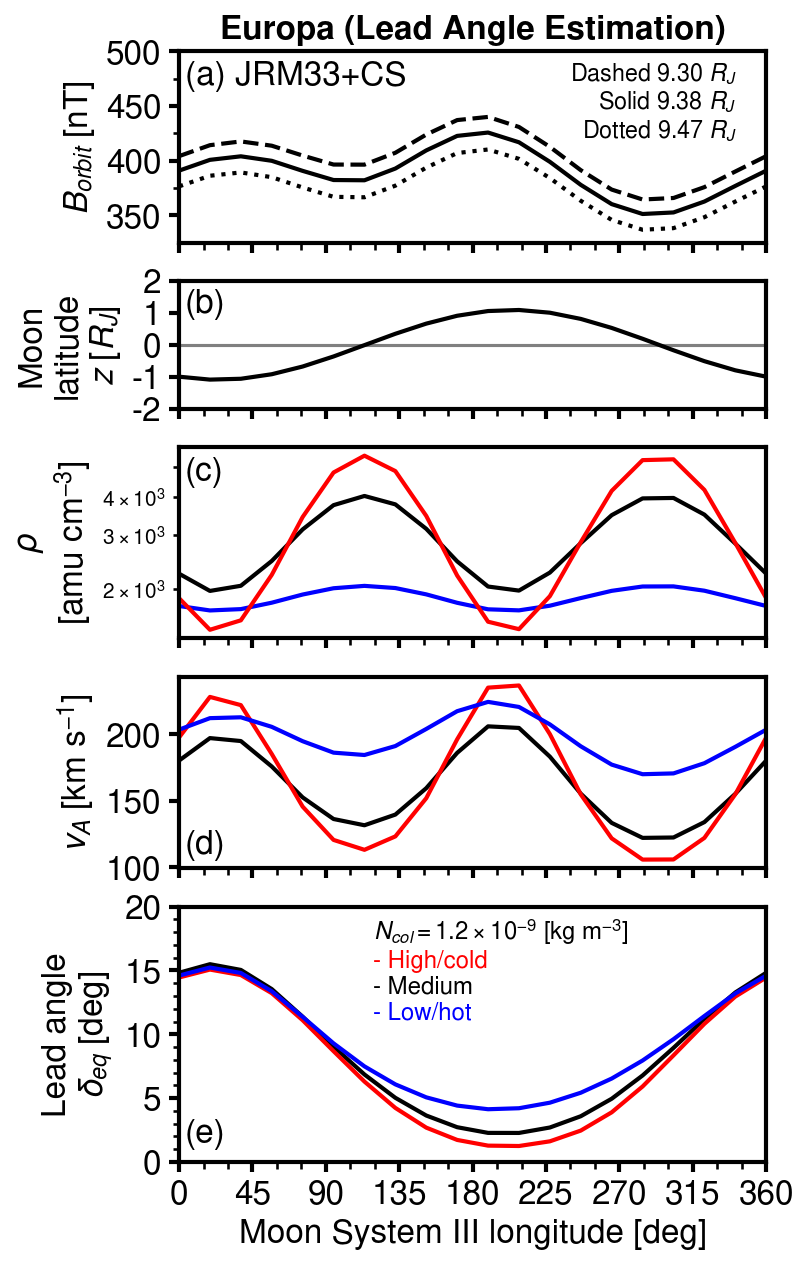

In [61]:
fsize = 16
fig, ax = plt.subplots(5, 1, figsize=(4.7, 8), dpi=150,
                       height_ratios=[3, 2, 3, 3, 4])
plt.subplots_adjust(left=0.2, top=0.95)
fig.tight_layout()
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す

ax[0].set_title(MOON+' (Lead Angle Estimation)', weight='bold', fontsize=fsize)
ax[0].set_ylim(325, 500)
ax[0].set_ylabel('$B_{orbit}$ [nT]', fontsize=fsize)
ax[0].set_yticks(np.arange(350, 501, 50))
ax[0].set_yticklabels(np.arange(350, 501, 50))
ax[0].plot(np.degrees(S3wlon), B*(1E+9),
           linestyle='solid', linewidth=2, color='k')
ax[0].plot(np.degrees(S3wlon), B_close*(1E+9),
           linestyle='dashed', linewidth=2, color='k')
ax[0].plot(np.degrees(S3wlon), B_far*(1E+9),
           linestyle='dotted', linewidth=2, color='k')
ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax[0].text(0.01, 0.95, '(a) JRM33+CS', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fsize)
ax[0].text(0.95, 0.95,
           'Dashed 9.30 $R_J$\nSolid 9.38 $R_J$\nDotted 9.47 $R_J$',
           color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fsize*0.7)

ax[1].set_ylim(-2.0, 2.0)
ax[1].set_ylabel('Moon\nlatitude\n$z$ [$R_J$]', fontsize=fsize)
ax[1].set_yticks(np.arange(-2, 3, 1))
ax[1].set_yticklabels(np.arange(-2, 3, 1))
ax[1].plot(np.degrees(S3wlon), rvec[2, :]/RJ, linewidth=2, color='k')
ax[1].axhline(y=0, color='gray', linestyle='solid', zorder=0.5)
ax[1].text(0.01, 0.94, '(b)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fsize)

# ax[2].set_ylim(-2.0, 2.0)
ax[2].set_ylabel('$\\rho$\n[amu cm$^{-3}$]', fontsize=fsize)
# ax[2].set_yticks(np.arange(-2, 3, 1))
# ax[2].set_yticklabels(np.arange(-2, 3, 1))
ax[2].set_yscale('log')
ax[2].plot(np.degrees(S3wlon), rho_1/(1E+6)/AMU, linewidth=2, color='b')
ax[2].plot(np.degrees(S3wlon), rho_2/(1E+6)/AMU, linewidth=2, color='k')
ax[2].plot(np.degrees(S3wlon), rho_3/(1E+6)/AMU, linewidth=2, color='r')
ax[2].text(0.01, 0.95, '(c)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[2].transAxes,
           fontsize=fsize)

# ax[3].set_ylim(150, 600)
ax[3].set_ylabel('$v_A$ [km s$^{-1}$]', fontsize=fsize)
ax[3].set_yticks(np.arange(100, 601, 50))
ax[3].set_yticklabels(np.arange(100, 601, 50))
ax[3].plot(np.degrees(S3wlon), VA_2/1000,
           linestyle='solid', linewidth=2, color='k')
ax[3].plot(np.degrees(S3wlon), VA_3/1000,
           linestyle='solid', linewidth=2, color='r')
ax[3].plot(np.degrees(S3wlon), VA_1/1000,
           linestyle='solid', linewidth=2, color='b')
ax[3].text(0.01, 0.2, '(d)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[3].transAxes,
           fontsize=fsize)

ax[4].set_ylim(0, 20)
ax[4].set_xlabel("Moon System III longitude [deg]", fontsize=fsize)
ax[4].set_ylabel('Lead angle\n$\delta_{eq}$ [deg]', fontsize=fsize)
ax[4].set_yticks(np.arange(0, 21, 5))
ax[4].set_yticklabels(np.arange(0, 21, 5))
ax[4].plot(np.degrees(S3wlon), leadangle_M,
           linestyle='solid', linewidth=2, color='k')
ax[4].plot(np.degrees(S3wlon), leadangle_H,
           linestyle='solid', linewidth=2, color='r')
ax[4].plot(np.degrees(S3wlon), leadangle_L,
           linestyle='solid', linewidth=2, color='b')
ax[4].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[4].text(0.01, 0.17, '(e)', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize)
ax[4].text(0.33, 0.63, '- Low/hot', color='b',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.72)
ax[4].text(0.33, 0.73, '- Medium', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.72)
ax[4].text(0.33, 0.83, '- High/cold', color='r',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.72)
ax[4].text(0.33, 0.96, '$N_{col}=1.2\\times 10^{-9}$ [kg m$^{-3}$]', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.72)
"""ax[4].text(0.3, 0.96, 'Scenarios by Bagenal+2015', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[4].transAxes,
           fontsize=fsize*0.72)"""
# fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.2)
plt.show()